In [37]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import time

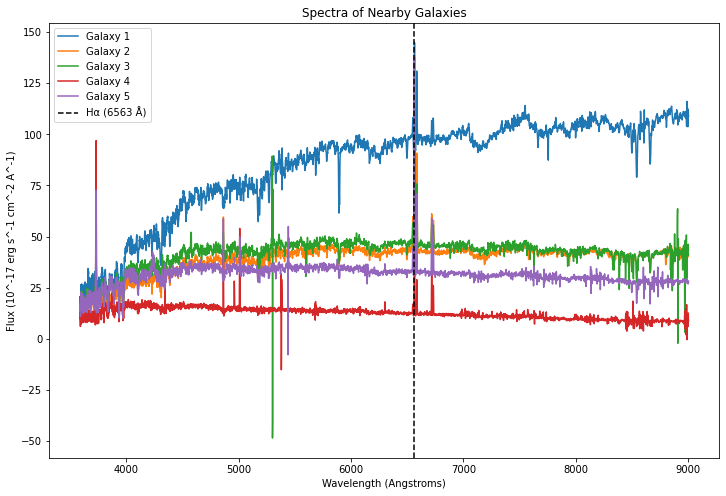

In [6]:
# Open the FITS file
hdu_list = fits.open('specgrid.fits')

# Extract log10 of wavelength (logwave) and flux (spectra)
logwave = hdu_list['LOGWAVE'].data
flux = hdu_list['FLUX'].data

# Convert logwave back to linear scale (wavelength in Angstroms)
wavelength = 10**logwave

plt.figure(figsize = (12,8))

# Plot a handful of the spectra
for i in range(5):  # Plot first 5 galaxies
    plt.plot(wavelength, flux[i], label=f'Galaxy {i+1}')


plt.axvline(x=6563, color='k', linestyle='--', label='Hα (6563 Å)')

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (10^-17 erg s^-1 cm^-2 A^-1)')
plt.title('Spectra of Nearby Galaxies')
plt.legend()
plt.show()


In [3]:
normalizations = []

# Normalize the flux for each galaxy
normalized_flux = np.zeros_like(flux)
for i in range(flux.shape[0]):
    # Compute the integral of the flux using the trapezoidal rule
    integral = np.trapz(flux[i], x=wavelength)
    
    # Store the normalization factor
    normalizations.append(integral)
    
    # Normalize the flux
    normalized_flux[i] = flux[i] / integral


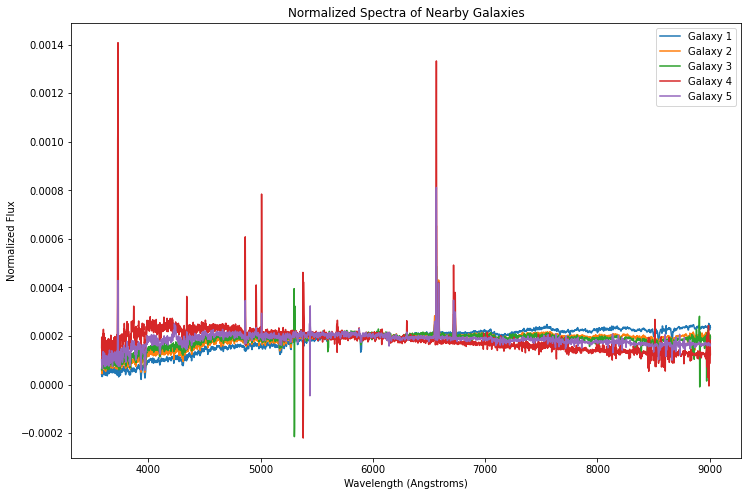

In [56]:
plt.figure(figsize = (12,8))
# Plot a handful of normalized spectra
for i in range(5):  # Plot first 5 galaxies
    plt.plot(wavelength, normalized_flux[i], label=f'Galaxy {i+1}')

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title('Normalized Spectra of Nearby Galaxies')
plt.legend()
plt.show()

In [58]:
# Compute the mean spectrum across all galaxies
mean_spectrum = np.mean(normalized_flux, axis=0)

# Subtract the mean spectrum from each galaxy's spectrum to get residuals
residuals = normalized_flux - mean_spectrum



# # Plot the mean spectrum
# plt.plot(wavelength, mean_spectrum, color='black', label='Mean Spectrum')
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Mean Normalized Flux')
# plt.title('Mean Spectrum of Galaxies')
# plt.legend()
# plt.show()

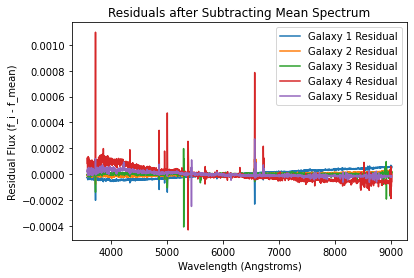

In [10]:
# # Plot a handful of residual spectra (f_i - f_mean)
# for i in range(5):  # Plot residuals for first 5 galaxies
#     plt.plot(wavelength, residuals[i], label=f'Galaxy {i+1} Residual')

# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Residual Flux (f_i - f_mean)')
# plt.title('Residuals after Subtracting Mean Spectrum')
# plt.legend()
# plt.show()



Now, 'residuals' contains the spectra of each galaxy after the mean has been subtracted.

In [59]:
# Number of galaxies (Ngal) and wavelengths (Nwave)
Ngal = residuals.shape[0]
Nwave = residuals.shape[1]

# Compute the covariance matrix: C = (1 / Ngal) * (R @ R.T)
cov_matrix = (1 / Ngal) * np.dot(residuals.T, residuals)  # R.T @ R gives a Nwave x Nwave matrix


In [60]:
start_time_eig = time.time()
# Find the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and corresponding eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]



end_time_eig = time.time()
time_eig = end_time_eig - start_time_eig

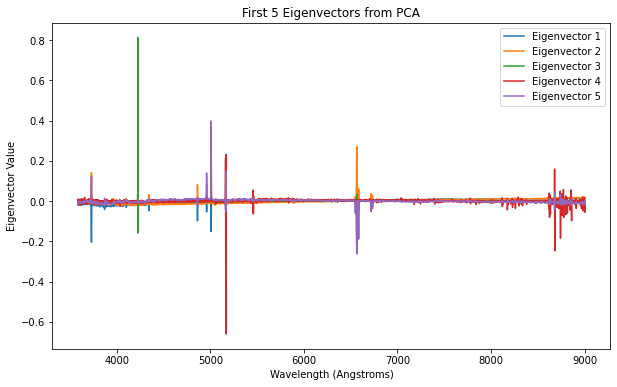

In [61]:
# Plot the first five eigenvectors
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(wavelength, eigenvectors[:, i], label=f'Eigenvector {i+1}')

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Eigenvector Value')
plt.title('First 5 Eigenvectors from PCA')
plt.legend()
plt.show()


In [40]:
start_time_svd = time.time()


# Perform Singular Value Decomposition
U, S, Vt = np.linalg.svd(residuals)

# The right singular vectors (V) are the eigenvectors of R^T * R
eigenvectors_svd = Vt.T  # Transpose to get them in the correct format

# Eigenvalues from S are the squares of the singular values
eigenvalues_svd = S**2  # Square the singular values to get eigenvalues


end_time_svd = time.time()
time_svd = end_time_svd - start_time_svd


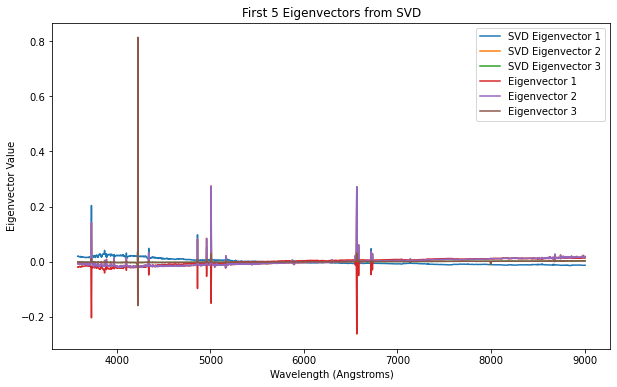

Eigenvalue Decomposition took 35.0224 seconds
SVD Decomposition took 84.3231 seconds


In [63]:
# Plot the first five eigenvectors obtained from SVD
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(wavelength, eigenvectors_svd[:, i], label=f'SVD Eigenvector {i+1}')
for i in range(3):
    plt.plot(wavelength, eigenvectors[:, i], label=f'Eigenvector {i+1}')

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Eigenvector Value')
plt.title('First 5 Eigenvectors from PCA')


plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Eigenvector Value')
plt.title('First 5 Eigenvectors from SVD')
plt.legend()
plt.show()


print(f"Eigenvalue Decomposition took {time_eig:.4f} seconds")
print(f"SVD Decomposition took {time_svd:.4f} seconds")


In [62]:
# Condition number of the residuals matrix (R)
cond_R = np.linalg.cond(residuals)
print(f"Condition number of R: {cond_R}")

# Condition number of the covariance matrix (C)
cond_C = np.linalg.cond(cov_matrix)
print(f"Condition number of C: {cond_C}")



Condition number of R: 4133915.5
Condition number of C: 60405755904.0


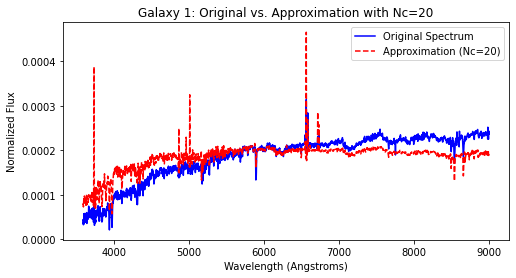

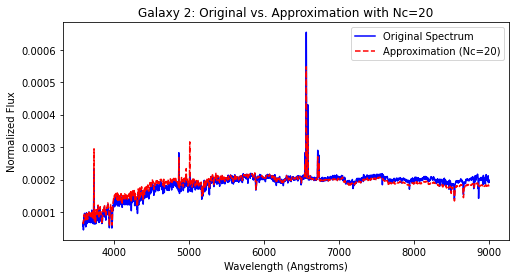

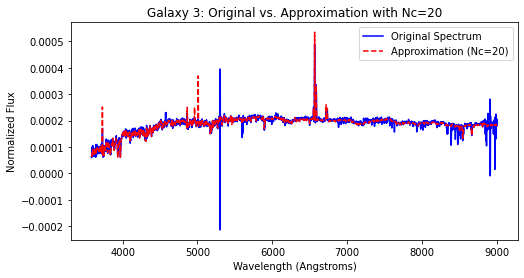

In [54]:
Nc = 20  # Number of components to keep
mean_spectrum = np.mean(normalized_flux, axis=0)

# Step 1: Rotate the spectra into the eigenspectrum basis to get the coefficients
coefficients = np.dot(residuals, eigenvectors[:, :Nc])

# Step 2: Reconstruct the approximate spectra using only the first Nc components
approx_spectra = np.dot(coefficients, eigenvectors[:, :Nc].T) + mean_spectrum

# Step 3: Plot a handful of original and approximated spectra for comparison
for i in range(3):  # Compare first 5 galaxies
    plt.figure(figsize=(8, 4))
    plt.plot(wavelength, normalized_flux[i], label='Original Spectrum', color='blue')
    plt.plot(wavelength, approx_spectra[i], label=f'Approximation (Nc={Nc})', color='red', linestyle='--')
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Normalized Flux')
    plt.title(f'Galaxy {i+1}: Original vs. Approximation with Nc={Nc}')
    plt.legend()
    plt.show()

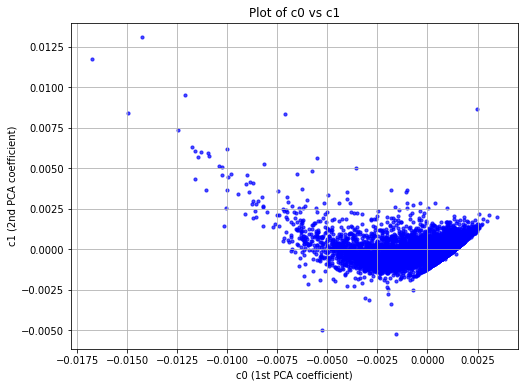

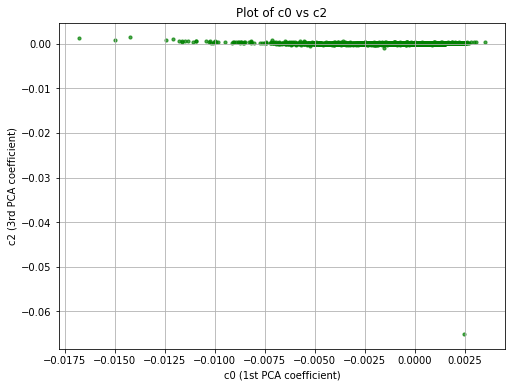

In [46]:
# Plot c0 vs c1
plt.figure(figsize=(8, 6))
plt.scatter(coefficients[:, 0], coefficients[:, 1], s=10, color='blue', alpha=0.7)
plt.xlabel('c0 (1st PCA coefficient)')
plt.ylabel('c1 (2nd PCA coefficient)')
plt.title('Plot of c0 vs c1')
plt.grid(True)
plt.show()

# Plot c0 vs c2
plt.figure(figsize=(8, 6))
plt.scatter(coefficients[:, 0], coefficients[:, 2], s=10, color='green', alpha=0.7)
plt.xlabel('c0 (1st PCA coefficient)')
plt.ylabel('c2 (3rd PCA coefficient)')
plt.title('Plot of c0 vs c2')
plt.grid(True)
plt.show()

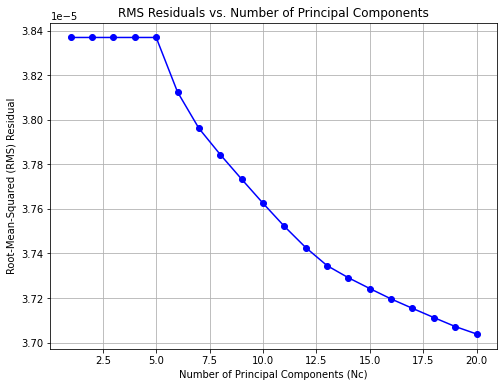

IndexError: index 20 is out of bounds for axis 0 with size 20

In [65]:
# Initialize lists to store the sum of squared residuals (SSR) and RMS residuals
squared_residuals = []

# Loop over Nc = 1 to 20
for Nc in range(1, 21):  # Nc should range from 1 to 20 (not starting at 0)
    # Reconstruct the spectra using Nc components
    # coefficients[:, :Nc] is (9713, Nc), eigenvectors[:, :Nc] is (4001, Nc)
    approx_spectra = np.dot(coefficients[:, :Nc], eigenvectors[:, :Nc].T) + mean_spectrum  # Ensure Nc eigenvectors are used

    # Compute the squared residuals (SSR = sum of squared differences)
    residuals = normalized_flux - approx_spectra
    squared_residual = np.sum(residuals**2)
    squared_residuals.append(squared_residual)



# Convert squared residuals to RMS residuals
rms_residuals = np.sqrt(np.array(squared_residuals) / normalized_flux.size)

# Plot the sum of squared residuals as a function of Nc
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), rms_residuals, marker='o', color='blue')
plt.xlabel('Number of Principal Components (Nc)')
plt.ylabel('Root-Mean-Squared (RMS) Residual')
plt.title('RMS Residuals vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Print the RMS residual for Nc = 20
print(f"RMS residual for Nc = 20: {rms_residuals[19]:.6f}")

In [71]:
# Print the RMS residual for Nc = 20
print(f"RMS residual for Nc = 20: {rms_residuals[-1]:.6f}")


RMS residual for Nc = 20: 0.000037
